# Repeat Buyer Prediction
#### Haopeng Huang, Ashutosh Jha, Muci Yu

## Introduction

Merchants sometimes run big promotions (e.g., discounts or cash coupons) on particular dates (e.g., Boxing-day Sales, "Black Friday" or "Double 11 (Nov 11th)" , in order to attract a large number of new buyers. Unfortunately, many of the attracted buyers are one-time deal hunters, and these promotions may have little long lasting impact on sales. To alleviate this problem, it is important for merchants to identify who can be converted into repeated buyers. By targeting on these potential loyal customers, merchants can greatly reduce the promotion cost and enhance the return on investment (ROI). It is well known that in the field of online advertising, customer targeting is extremely challenging, especially for fresh buyers. However, with the long-term user behavior log accumulated by Tmall.com, we may be able to solve this problem. In this challenge, we provide a set of merchants and their corresponding new buyers acquired during the promotion on the "Double 11" day. Your task is to predict which new buyers for given merchants will become loyal customers in the future. In other words, you need to predict the probability that these new buyers would purchase items from the same merchants again within 6 months. A data set containing around 200k users is given for training, while the other of similar size for testing. Similar to other competitions, you may extract any features, then perform training with additional tools. You need to only submit the prediction results for evaluation. 

[Link to the competition](https://tianchi.aliyun.com/competition/entrance/231576/introduction)

## High Level Workflow

### Data Cleaning/Preprocessing
    - Missing value in user_info.age_range
    - Group user_id and mercent_id into one single attribute
    - Create dummy variables for categorical data
    - Feature Selection Through Tree Classifiers
    - Feature Engineering (for every [user, merchant] combination):
        1. Average number of {click, save, purchase} activity 
        2. for each {brand, category}
        3. weighted by his with other merchants

In [1]:
#Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Read data
data_format1 = 'Data/data_format1/'
data_format2 = 'Data/data_format2/'

In [3]:
!ls Data/data_format1

test_format1.csv      user_info_format1.csv
train_format1.csv     user_log_format1.csv


In [4]:
# Import Data
user_info1 = pd.read_csv(data_format1+'user_info_format1.csv')
user_log1 = pd.read_csv(data_format1 + "user_log_format1.csv")
train_format1 = pd.read_csv(data_format1 + "train_format1.csv")
submission_format1 = pd.read_csv(data_format1 + "test_format1.csv")

## Data Cleaning

**How to deal with missing value?**

In [5]:
data_missing = (user_info1.age_range.isnull() | user_info1.gender.isnull())
data_total = user_info1.size
print('There are in total {} rows (out of {}) that contain missing value.'.format(data_missing.sum(),data_total))
print('Data lost if we drop all the users with missing data :')
print('{:.3f} of the total user info data we have.'.format(data_missing.sum()/data_total))

There are in total 6462 rows (out of 1272510) that contain missing value.
Data lost if we drop all the users with missing data :
0.005 of the total user info data we have.


This instances with missing values are only a small part of our data, so let's drop them for now. May come back later to discover some other ways to deal with missing value.

In [6]:
# user_info_ : user_info_ df after dropping missing values
user_info_ = user_info1[-data_missing]
print(user_info_.isnull().sum())
print("Remaining dataframe size: ", user_info_.size)
print("Remaining number of unique users: ", user_info_.user_id.size)
user_info_.head()

user_id      0
age_range    0
gender       0
dtype: int64
Remaining dataframe size:  1253124
Remaining number of unique users:  417708


,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


**Dataframes to create:**

    1.df_train: user_id, merchant_id, user_merchant, etc
            - Map from train_format1 with user_merchant
    2.df_test: user_id, merchant_id, user_merchant, etc
            - Map from test_format1 with user_merchant

In [8]:
train_format1['user_merchant'] = train_format1.user_id.astype(str)+'_'+train_format1.merchant_id.astype(str)
submission_format1['user_merchant'] = submission_format1.user_id.astype(str)+'_'+submission_format1.merchant_id.astype(str)
user_log1['user_merchant'] = user_log1.user_id.astype(str)+'_'+user_log1.seller_id.astype(str)

In [9]:
import time
start_time = time.clock()
user_log = user_log1.sort_values(by = ['user_id', 'seller_id'], ascending = True)
print(time.clock() - start_time, "seconds")
user_log.head()

20.732054000000005 seconds


,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,user_merchant
23288879,1,638653,389,471,3431.0,1111,0,1_471
23288864,1,556107,1252,739,6822.0,1018,0,1_739
23288886,1,504149,1023,925,7402.0,1011,0,1_925
23288887,1,504149,1023,925,7402.0,1011,0,1_925
23288888,1,504149,1023,925,7402.0,1011,2,1_925


In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(train_format1, test_size = 0.3, random_state = 123)

In [11]:
df_train.head()

,user_id,merchant_id,label,user_merchant
117658,306139,4015,0,306139_4015
63511,183867,3936,0,183867_3936
5225,193167,2977,0,193167_2977
47781,27660,3608,0,27660_3608
193470,149690,2273,0,149690_2273


In [12]:
start_time = time.clock()
aset = set(df_train.user_merchant)
user_log_train_mask = [x in aset for x in user_log.user_merchant]
print(time.clock() - start_time, "seconds")

7.250081999999992 seconds


In [13]:
start_time = time.clock()
aset_test = set(df_test.user_merchant)
user_log_test_mask = [x in aset_test for x in user_log.user_merchant]
print(time.clock() - start_time, "seconds")

4.916499000000016 seconds


In [14]:
print(np.array(user_log_train_mask).sum())
print(np.array(user_log_test_mask).sum())

1978692
845549


In [15]:
user_log_train = user_log[user_log_train_mask]
user_log_test = user_log[user_log_test_mask]

print(user_log_train.shape)
print(user_log_test.shape)

(1978692, 8)
(845549, 8)


In [16]:
label_dict = dict(zip(df_train.user_merchant, df_train.label))
user_log_train['label'] = user_log_train.user_merchant.apply(lambda x: label_dict[x])
user_log_train.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,user_merchant,label
48482122,6,559647,242,1356,8396.0,1111,2,6_1356,0
48482146,6,559647,242,1356,8396.0,1031,0,6_1356,0
48482166,6,559647,242,1356,8396.0,1111,0,6_1356,0
48482170,6,559647,242,1356,8396.0,1024,3,6_1356,0
48482079,6,348105,737,4249,3238.0,1019,3,6_4249,0


# Exploratory Data Analysis

**Who are the most popular merchants?**

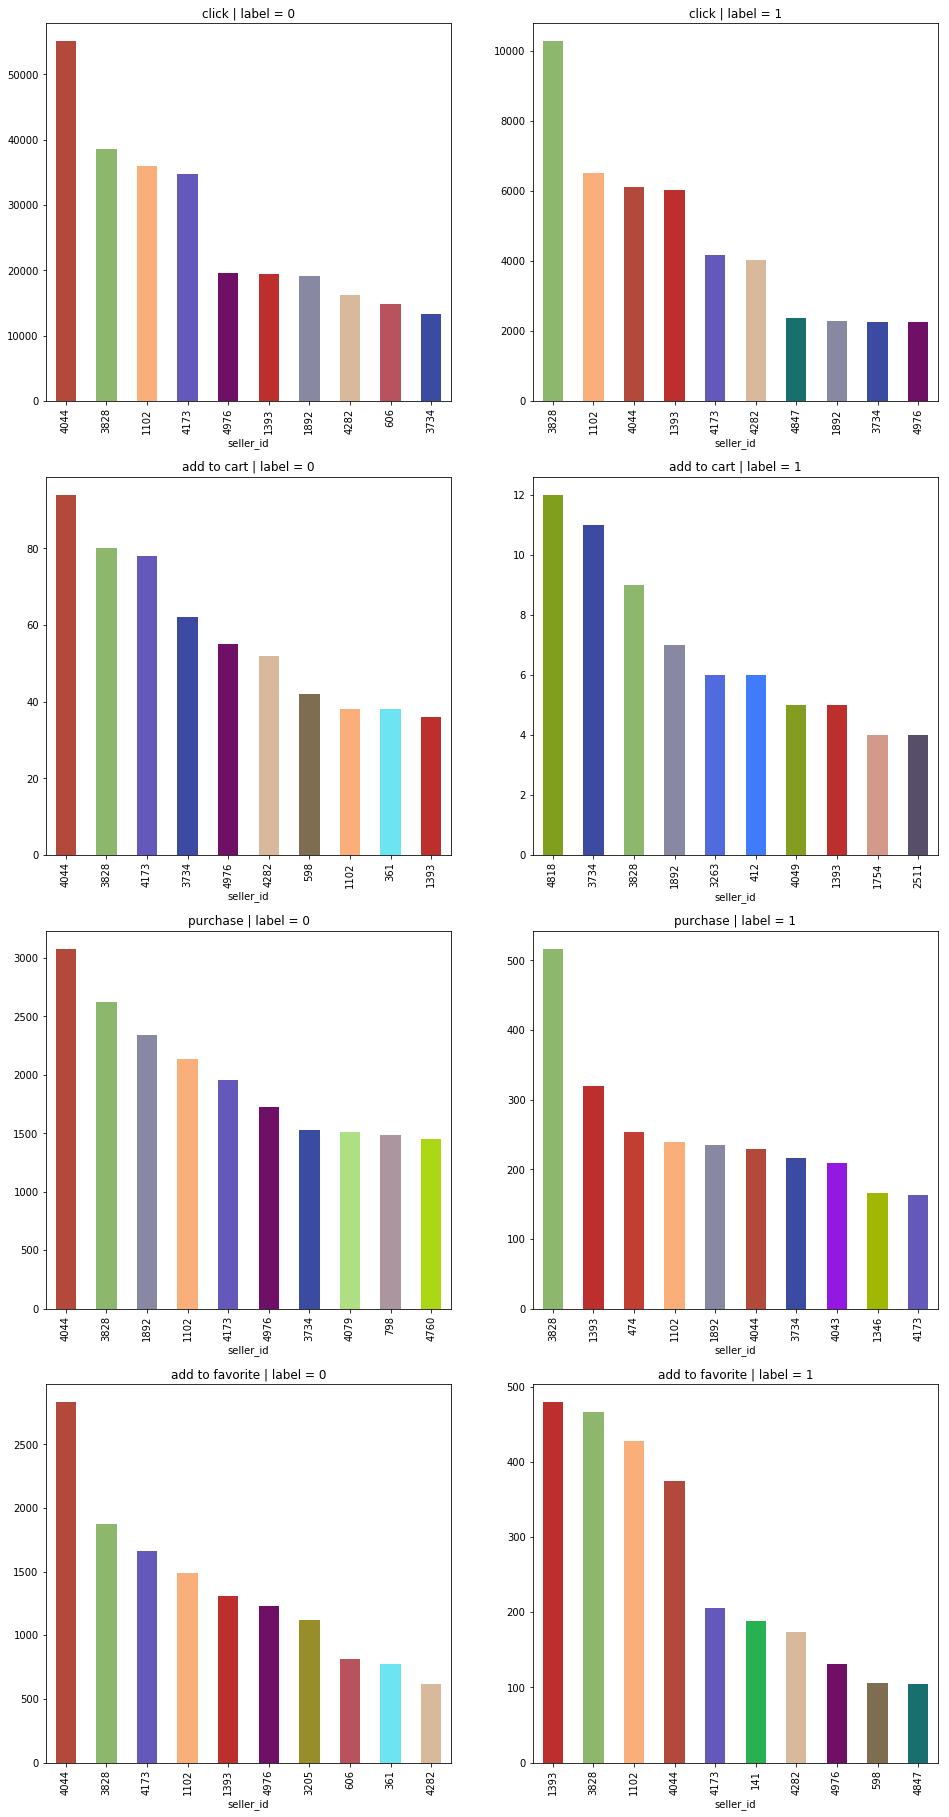

In [17]:
import warnings
warnings.simplefilter("ignore", UserWarning)

def assign_color(array):
    for x in array:
        if x not in color_dict:
            RGB = np.random.random(3)
            color_dict[x] = RGB
        else:
            pass
        
np.random.seed(123)
action_dict = {0:'click', 1:'add to cart', 2:'purchase', 3:'add to favorite'}
plt.figure(figsize = (16, 32))
count = 0
color_dict = {}
for typ in action_dict.keys():
    for label in user_log_train.label.unique():
        plt.subplot(421+count)
        count+=1
        merchant_sorted_10 = user_log_train[user_log_train.label == label][user_log_train.action_type == typ].groupby(by = 'seller_id').count().sort_values(by = 'item_id', ascending = False).iloc[:10,0]
        assign_color(merchant_sorted_10.index)
        color_list = [color_dict[x] for x in merchant_sorted_10.index]
        merchant_sorted_10.plot(kind = 'bar', title = action_dict[typ]+' | '+'label = '+str(label), color = color_list)

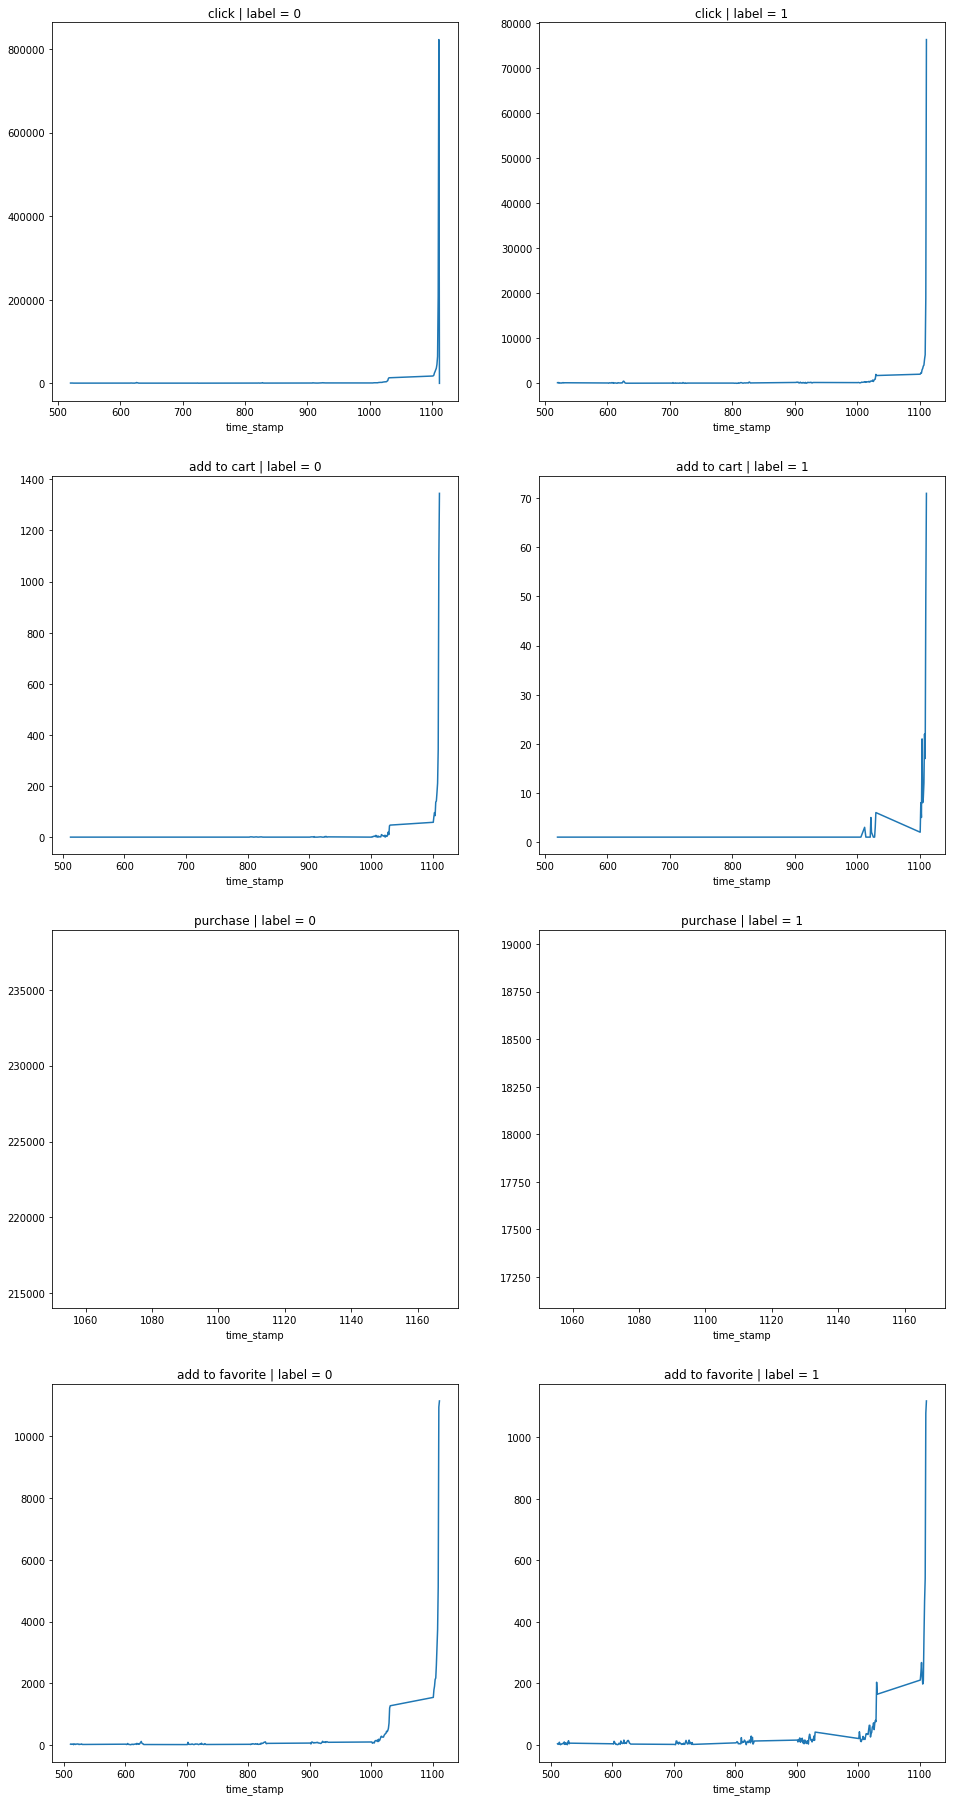

In [18]:
np.random.seed(123)
action_dict = {0:'click', 1:'add to cart', 2:'purchase', 3:'add to favorite'}
plt.figure(figsize = (16, 32))
count = 0
color_dict = {}
for typ in action_dict.keys():
    for label in user_log_train.label.unique():
        plt.subplot(421+count)
        count+=1
        time_sorted = user_log_train[user_log_train.label == label][user_log_train.action_type == typ].groupby(by = 'time_stamp').count().sort_values(by = 'time_stamp', ascending = True).iloc[:,0]
        time_sorted.plot(title = action_dict[typ]+' | '+'label = '+str(label))

In [135]:
time_sorted = user_log_train[user_log_train.label == 1][user_log_train.action_type == 2].groupby(by = 'time_stamp').count().sort_values(by = 'time_stamp', ascending = True).iloc[:,0]

time_sorted

time_stamp
1111    15449
Name: user_id, dtype: int64

In [143]:
print(user_log_train[user_log_train.label == 0][user_log_train.action_type == 0].time_stamp.max())
print(user_log_train[user_log_train.label == 1][user_log_train.action_type == 0].time_stamp.max())

1112
1111


In [144]:
user_log_train[user_log_train.label == 0][user_log_train.action_type == 0][user_log_train.time_stamp == 1112]

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,user_merchant,label
30356092,19259,206627,301,4871,1105.0,1112,0,19259_4871,0
6460004,300578,512425,632,4648,7924.0,1112,0,300578_4648,0


In [145]:
user_log_train[user_log_train.time_stamp == 1112]

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,user_merchant,label
30356092,19259,206627,301,4871,1105.0,1112,0,19259_4871,0
6460004,300578,512425,632,4648,7924.0,1112,0,300578_4648,0


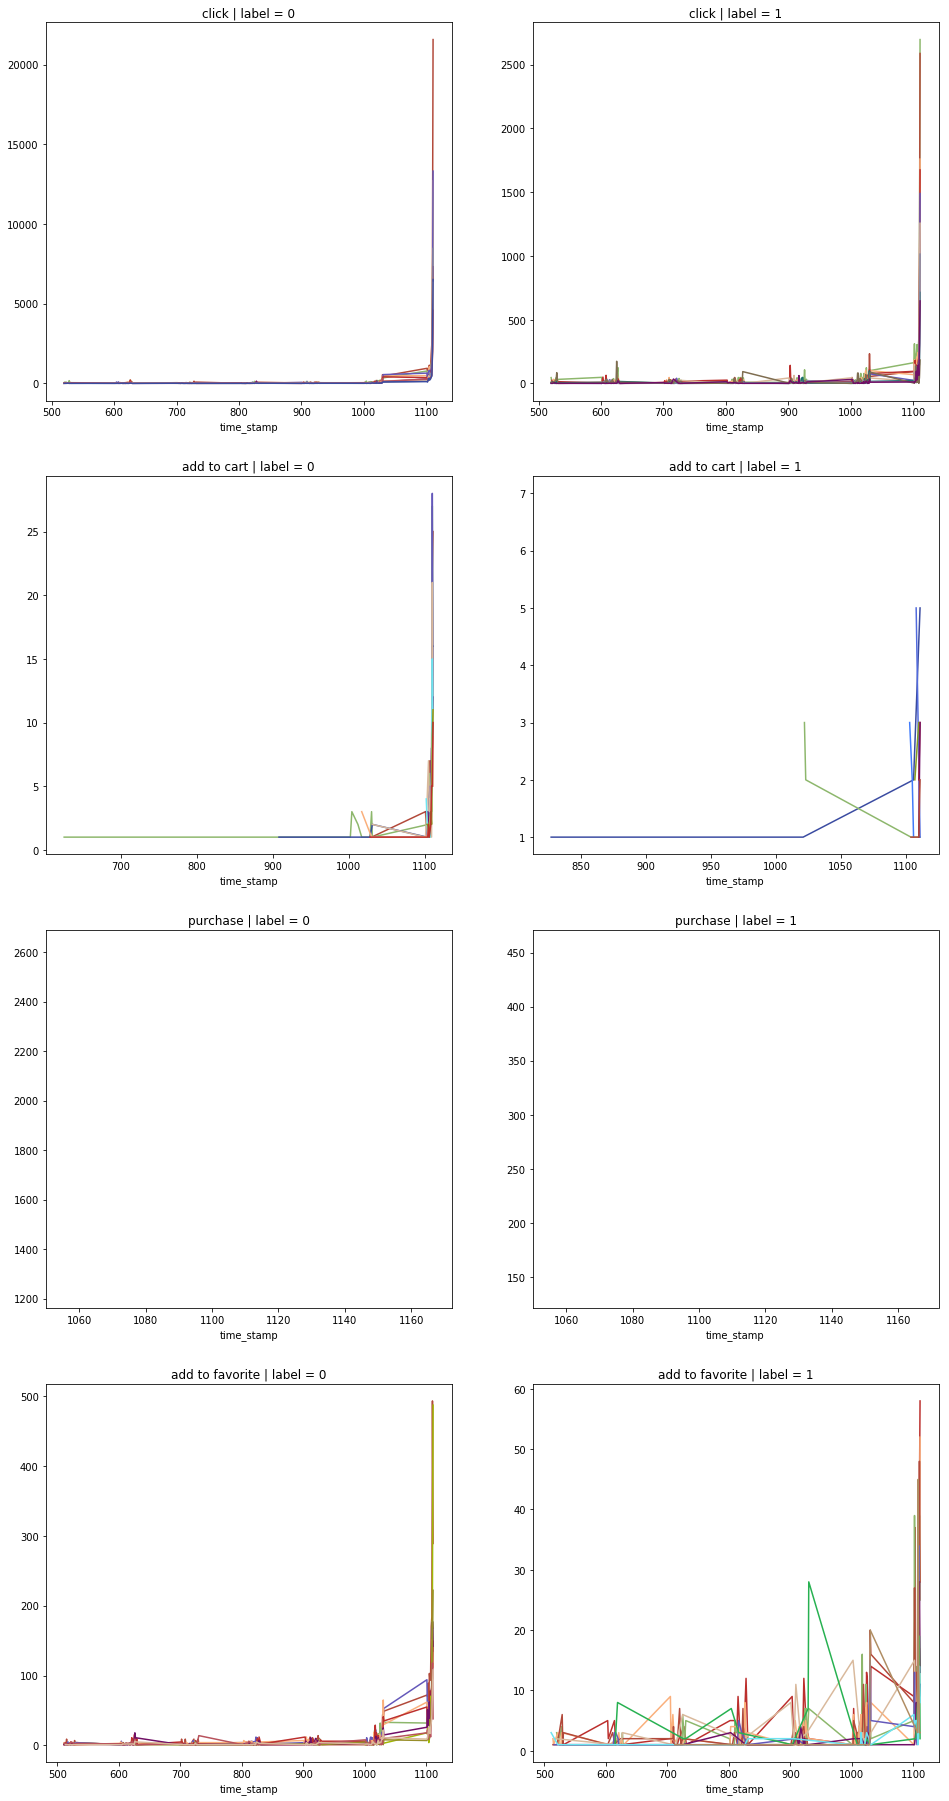

In [174]:
np.random.seed(123)
action_dict = {0:'click', 1:'add to cart', 2:'purchase', 3:'add to favorite'}
plt.figure(figsize = (16, 32))
count = 0
color_dict = {}
for typ in action_dict.keys():
    for label in user_log_train.label.unique():
        plt.subplot(421+count)
        count+=1
        merchant_sorted_10 = user_log_train[user_log_train.label == label][user_log_train.action_type == typ].groupby(by = 'seller_id').count().sort_values(by = 'item_id', ascending = False).iloc[:10,0]
        assign_color(merchant_sorted_10.index)
        color_list = [color_dict[x] for x in merchant_sorted_10.index]
        for merchant in merchant_sorted_10.index:
            mer_ts = user_log_train[user_log_train.seller_id == merchant][user_log_train.label == label][user_log_train.action_type == typ].groupby(by = 'time_stamp').count().iloc[:,0]
            mer_ts.plot(title = action_dict[typ]+' | '+'label = '+str(label), color = [color_dict[merchant]])
#         merchant_sorted_10.plot(kind = 'bar', title = action_dict[typ]+' | '+'label = '+str(label), color = color_list)

In [152]:
mask = user_log_train.seller_id.apply(lambda x: x in merchant_sorted_10)
seller_time_group = user_log_train[mask].groupby(by = ['seller_id', 'time_stamp']).count()

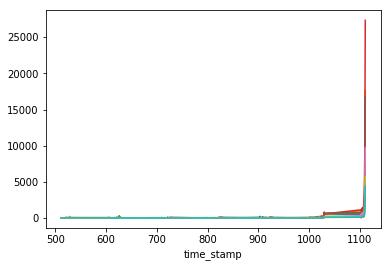

In [165]:
for merchant in merchant_sorted_10.index:
    mer_ts = user_log_train[user_log_train.seller_id == merchant].groupby(by = 'time_stamp').count().iloc[:,0]
    mer_ts.plot()
    except:
        print(merchant)
        print(mer_ts)

In [161]:
user_log_train[user_log_train.seller_id == 391]

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,user_merchant,label


In [164]:
merchant_sorted_10

seller_id
1393    415
3828    412
1102    391
4044    346
4282    159
4173    153
4976    115
2639     99
598      94
586      91
Name: user_id, dtype: int64

In [170]:
color_dict[2639]

array([0.15307052, 0.69552953, 0.31876643])

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

def assign_color(array):
    for x in array:
        if x not in color_dict:
            RGB = np.random.random(3)
            color_dict[x] = RGB
        else:
            pass
        
np.random.seed(123)
action_dict = {0:'click', 1:'add to cart', 2:'purchase', 3:'add to favorite'}
plt.figure(figsize = (16, 32))
count = 0
color_dict = {}
for typ in action_dict.keys():
    for label in user_log_train.label.unique():
        plt.subplot(421+count)
        count+=1
        merchant_sorted_10 = user_log_train[user_log_train.label == label][user_log_train.action_type == typ].groupby(by = 'seller_id').count().sort_values(by = 'item_id', ascending = False).iloc[:10,0]
        assign_color(merchant_sorted_10.index)
        color_list = [color_dict[x] for x in merchant_sorted_10.index]
        merchant_sorted_10.plot(kind = 'bar', title = action_dict[typ]+' | '+'label = '+str(label), color = color_list)

In [19]:
user_log_train.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,user_merchant,label
48482122,6,559647,242,1356,8396.0,1111,2,6_1356,0
48482146,6,559647,242,1356,8396.0,1031,0,6_1356,0
48482166,6,559647,242,1356,8396.0,1111,0,6_1356,0
48482170,6,559647,242,1356,8396.0,1024,3,6_1356,0
48482079,6,348105,737,4249,3238.0,1019,3,6_4249,0
